In [4]:
# Load test configuration from YAML file
import sys
import os
from pathlib import Path

# Set working directory to project root
project_root = Path.cwd().parent.parent
print(f"Current working directory: {Path.cwd()}")
print(f"Setting working directory to project root: {project_root}")
os.chdir(project_root)
print(f"New working directory: {Path.cwd()}")

# Add src to path so we can import the modules
sys.path.append(str(Path.cwd() / "src"))

from utils import load_yaml_config
from models import ExperimentConfig
from babel_ai.experiment import Experiment

# Load the test configuration
config_path = "configs/test_config.yaml"
config = load_yaml_config(ExperimentConfig, config_path)

print("Loaded configuration:")
print(f"- Fetcher: {config.fetcher_config.fetcher}")
print(f"- Analyzer: {config.analyzer_config.analyzer}")
print(f"- Max iterations: {config.max_iterations}")
print(f"- Max total characters: {config.max_total_characters}")
print(f"- Output directory: {config.output_dir}")
print(f"- Agent configs: {len(config.agent_configs)} agent(s)")

# Display the configuration
config


INFO:utils:Loading configuration from configs/test_config.yaml
INFO:utils:Successfully loaded ExperimentConfig from configs/test_config.yaml


Current working directory: /Users/mienhardt/Programming/babel_ai/notebooks/structured_analysis
Setting working directory to project root: /Users/mienhardt/Programming/babel_ai
New working directory: /Users/mienhardt/Programming/babel_ai
Loaded configuration:
- Fetcher: FetcherType.SHAREGPT
- Analyzer: AnalyzerType.SIMILARITY
- Max iterations: 50
- Max total characters: 100000
- Output directory: results
- Agent configs: 1 agent(s)


ExperimentConfig(fetcher_config=FetcherConfig(fetcher=<FetcherType.SHAREGPT: 'sharegpt'>, data_path='data/sharegpt_sample.json', second_data_path=None, category=None, min_messages=2, max_messages=10), analyzer_config=AnalyzerConfig(analyzer=<AnalyzerType.SIMILARITY: 'similarity'>, analyze_window=5), agent_configs=[AgentConfig(provider=<Provider.OPENAI: 'openai'>, model=<OpenAIModel.GPT4_1106_PREVIEW: 'gpt-4-1106-preview'>, system_prompt='You are a helpful assistant participating in a conversation.', temperature=0.7, max_tokens=150, frequency_penalty=0.0, presence_penalty=0.0, top_p=1.0)], agent_selection_method=<AgentSelectionMethod.ROUND_ROBIN: 'round_robin'>, max_iterations=50, max_total_characters=100000, output_dir='results')

In [ ]:
# Modify the configuration for testing
from models import AgentConfig, FetcherConfig, AnalyzerConfig
from babel_ai.enums import FetcherType, AnalyzerType, AgentSelectionMethod
from api.llm_interface import Provider
from api.openai import OpenAIModel
from api.azure_openai import AzureModel

# Create a modified configuration with smaller limits for testing
# and use random fetcher instead of sharegpt (which requires data files)
modified_config = ExperimentConfig(
    fetcher_config=FetcherConfig(
        fetcher=FetcherType.TOPICAL_CHAT,
        data_path="data/human_human_dataset/Topical-Chat/test_freq.jsonl",
        second_data_path="data/human_human_dataset/Topical-Chat/test_rare.jsonl",
        min_messages=5,
        max_messages=50,
    ),
    analyzer_config=AnalyzerConfig(
        analyzer=AnalyzerType.SIMILARITY,
        analyze_window=5  # Smaller window for testing
    ),
    agent_configs=[
        AgentConfig(
            provider=Provider.AZURE,
            model=AzureModel.GPT4O_2024_08_06,  # Use smaller model for testing
            system_prompt="You are a helpful assistant in a conversation.",
            temperature=0.8,
            max_tokens=100,  # Smaller for testing
            frequency_penalty=0.0,
            presence_penalty=0.0,
            top_p=1.0
        ),
        AgentConfig(
            provider=Provider.AZURE,
            model=AzureModel.GPT4O_2024_08_06,  # Use smaller model for testing
            system_prompt="Your task is to keep the conversation interesting and develop new angles.",
            temperature=1.2,
            max_tokens=100,  # Smaller for testing
            frequency_penalty=0.0,
            presence_penalty=0.0,
            top_p=1.0
        ),
    ],
    agent_selection_method=AgentSelectionMethod.ROUND_ROBIN,
    max_iterations=30,  # Much smaller for testing
    max_total_characters=100000,  # Smaller limit
    output_dir="data/test_results"
)

print("Modified configuration:")
print(f"- Fetcher: {modified_config.fetcher_config.fetcher}")
print(f"- Fetcher category: {modified_config.fetcher_config.category}")
print(f"- Analyzer window: {modified_config.analyzer_config.analyze_window}")
print(f"- Model: {modified_config.agent_configs[0].model}")
print(f"- Max iterations: {modified_config.max_iterations}")
print(f"- Max tokens per response: {modified_config.agent_configs[0].max_tokens}")
print(f"- Output directory: {modified_config.output_dir}")

modified_config


Modified configuration:
- Fetcher: FetcherType.TOPICAL_CHAT
- Fetcher category: None
- Analyzer window: 5
- Model: AzureModel.GPT4O_2024_08_06
- Max iterations: 30
- Max tokens per response: 100
- Output directory: data/test_results


ExperimentConfig(fetcher_config=FetcherConfig(fetcher=<FetcherType.TOPICAL_CHAT: 'topical_chat'>, data_path='data/human_human_dataset/Topical-Chat/test_freq.jsonl', second_data_path='data/human_human_dataset/Topical-Chat/test_rare.jsonl', category=None, min_messages=5, max_messages=10), analyzer_config=AnalyzerConfig(analyzer=<AnalyzerType.SIMILARITY: 'similarity'>, analyze_window=5), agent_configs=[AgentConfig(provider=<Provider.AZURE: 'azure'>, model=<AzureModel.GPT4O_2024_08_06: 'gpt-4o-2024-08-06'>, system_prompt='You are a helpful assistant in a conversation.', temperature=0.8, max_tokens=100, frequency_penalty=0.0, presence_penalty=0.0, top_p=1.0), AgentConfig(provider=<Provider.AZURE: 'azure'>, model=<AzureModel.GPT4O_2024_08_06: 'gpt-4o-2024-08-06'>, system_prompt='Your task is to keep the conversation interesting and develop new angles.', temperature=1.2, max_tokens=100, frequency_penalty=0.0, presence_penalty=0.0, top_p=1.0)], agent_selection_method=<AgentSelectionMethod.ROUN

In [35]:
# Run the experiment with modified configuration
import logging
from datetime import datetime

# Set up logging to see what's happening
logging.basicConfig(level=logging.INFO)

print("Starting experiment...")
print(f"Timestamp: {datetime.now()}")

# Create and run the experiment
try:
    # Create experiment instance
    experiment = Experiment(
        config=modified_config,
        use_notebook_tqdm=True  # Use notebook-friendly progress bars
    )
    
    print(f"Experiment created successfully!")
    print(f"Output directory: {experiment.output_dir}")
    print(f"Initial messages from fetcher: {len(experiment.messages)}")
    
    # Run the experiment
    print("\nRunning experiment...")
    results = experiment.run()
    
    print(f"\nExperiment completed!")
    print(f"Total results: {len(results)}")
    print(f"Final message count: {len(experiment.messages)}")
    print(f"Total characters: {experiment.total_characters}")
    
    # Show summary of results
    print("\nResults summary:")
    for i, result in enumerate(results):
        print(f"  {i+1}. {result.role}: {result.content[:60]}...")
    
    # Store results for next cell
    experiment_results = results
    output_directory = experiment.output_dir
    
    print(f"\nResults saved to: {output_directory}")
    
except Exception as e:
    print(f"Error running experiment: {e}")
    import traceback
    traceback.print_exc()


INFO:babel_ai.prompt_fetcher:Loaded 0 conversations from Topical-Chat dataset
INFO:api.azure_openai:Sending request to Azure OpenAI API with model gpt-4o-2024-08-06, temperature 0.8, max_tokens 100


Starting experiment...
Timestamp: 2025-07-09 16:27:29.960736
Experiment created successfully!
Output directory: data/test_results
Initial messages from fetcher: 0

Running experiment...


INFO:httpx:HTTP Request: POST https://chm-openai.openai.azure.com/openai/deployments/gpt-4o-2024-08-06/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:api.azure_openai:Successfully received response from Azure OpenAI API
INFO:api.azure_openai:Sending request to Azure OpenAI API with model gpt-4o-2024-08-06, temperature 1.2, max_tokens 100
INFO:httpx:HTTP Request: POST https://chm-openai.openai.azure.com/openai/deployments/gpt-4o-2024-08-06/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:api.azure_openai:Successfully received response from Azure OpenAI API
INFO:api.azure_openai:Sending request to Azure OpenAI API with model gpt-4o-2024-08-06, temperature 0.8, max_tokens 100
INFO:httpx:HTTP Request: POST https://chm-openai.openai.azure.com/openai/deployments/gpt-4o-2024-08-06/chat/completions?api-version=2024-10-01-preview "HTTP/1.1 200 OK"
INFO:api.azure_openai:Successfully received response from Azure OpenAI API
INFO:api.azure_openai:Sendin

KeyboardInterrupt: 

Examining output files...
Looking in directory: data/test_results
Found 7 CSV files and 7 JSON files
Using metadata file: drift_experiment_20250709_162114_meta.json
=== EXPERIMENT METADATA ===
Timestamp: 2025-07-09 16:21:14.590068

Fetcher Type: FetcherType.SHAREGPT
Number of Fetched Messages: 10

Analyzer Type: AnalyzerType.SIMILARITY
Analyzer Window: 5

Agent Data:
  Agent 1:
    Provider: Provider.AZURE
    Model: AzureModel.GPT4O_2024_08_06
    Temperature: 0.8
    Max Tokens: 100
    Frequency Penalty: 0.0
    Presence Penalty: 0.0
    Top P: 1.0

  Agent 2:
    Provider: Provider.AZURE
    Model: AzureModel.GPT4O_2024_08_06
    Temperature: 1.2
    Max Tokens: 100
    Frequency Penalty: 0.0
    Presence Penalty: 0.0
    Top P: 1.0

Agent Selection Method: AgentSelectionMethod.ROUND_ROBIN
Total Iterations: 30
Total Characters: 27945

=== ANALYSIS RESULTS VISUALIZATION ===
Using CSV file: drift_experiment_20250709_162114.csv
Loaded DataFrame with shape: (30, 8)
Columns: ['iteration

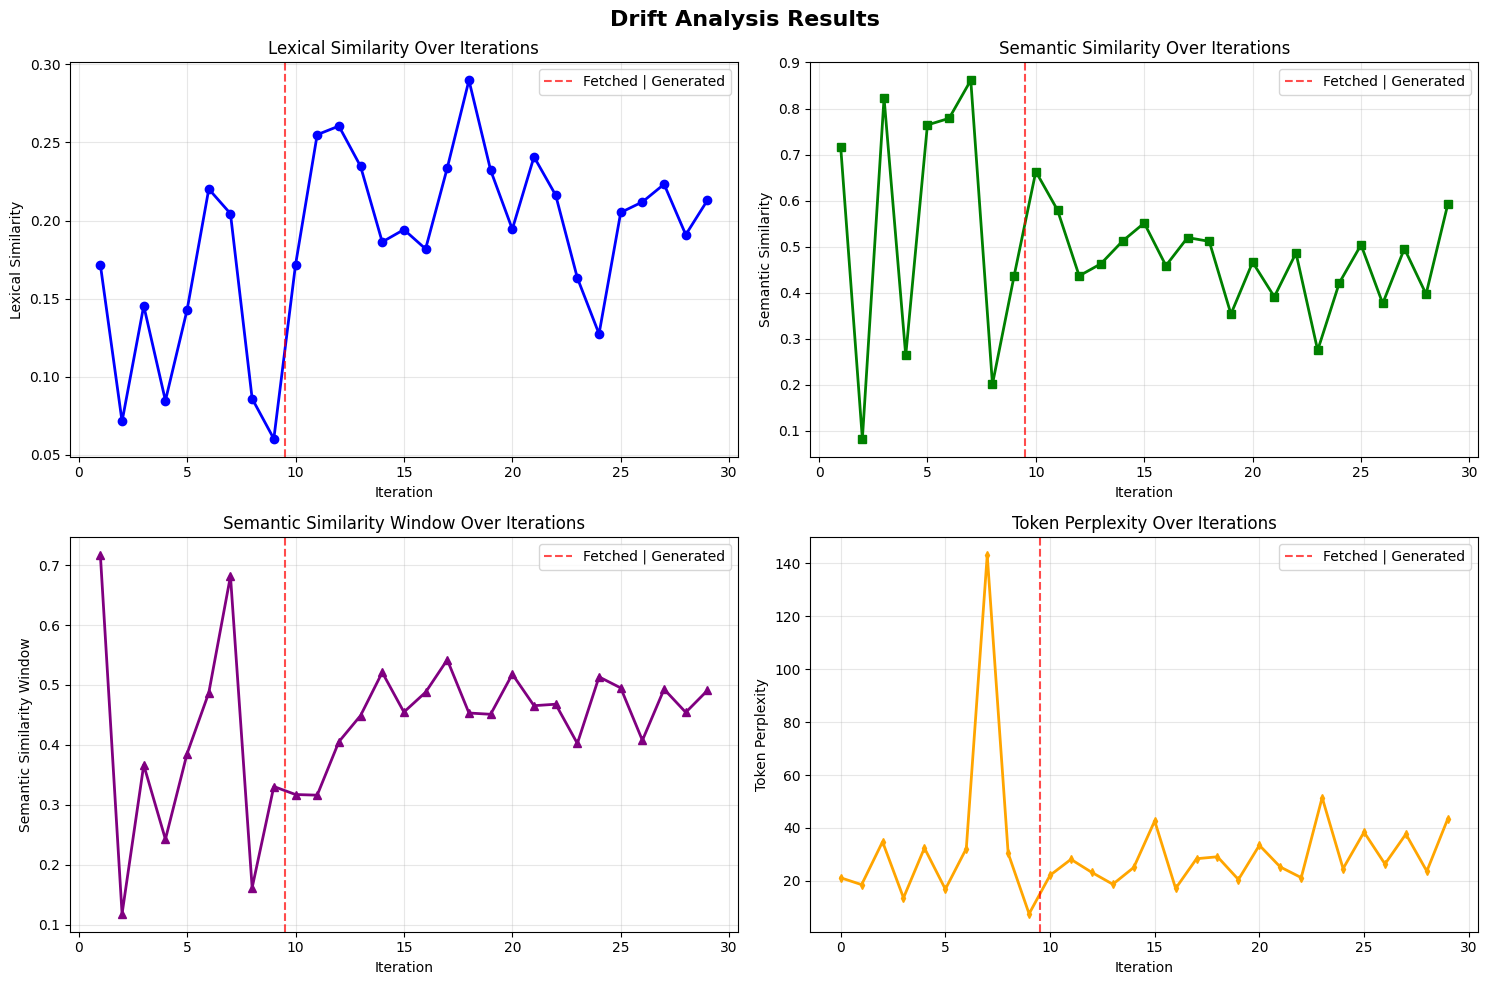


Dataset Summary:
  Shape: (30, 18)
  Total iterations: 30

Available Analysis Metrics:
  - word_count: 30 non-null values
  - unique_word_count: 30 non-null values
  - coherence_score: 30 non-null values
  - lexical_similarity: 29 non-null values
  - semantic_similarity: 29 non-null values
  - lexical_similarity_window: 29 non-null values
  - semantic_similarity_window: 29 non-null values
  - token_perplexity: 30 non-null values

Requested Metric Statistics:
       lexical_similarity  semantic_similarity  semantic_similarity_window  \
count           29.000000            29.000000                   29.000000   
mean             0.186638             0.495926                    0.434321   
std              0.057808             0.181378                    0.127081   
min              0.060345             0.082729                    0.118091   
25%              0.163265             0.396865                    0.385508   
50%              0.194444             0.486179                    0.

In [30]:
# Examine the output files and create visualizations
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pathlib import Path

print("Examining output files...")

try:
    # Ensure output_directory is a Path object
    if 'output_directory' not in locals():
        output_directory = Path("data/test_results")
    else:
        output_directory = Path(output_directory)
    
    print(f"Looking in directory: {output_directory}")
    
    # Find the CSV and JSON files
    csv_files = list(output_directory.glob("*.csv"))
    json_files = list(output_directory.glob("*_meta.json"))
    
    print(f"Found {len(csv_files)} CSV files and {len(json_files)} JSON files")
    
    if json_files:
        # Load metadata (use the most recent one)
        json_file = sorted(json_files)[-1]
        print(f"Using metadata file: {json_file.name}")
        
        with open(json_file, 'r') as f:
            metadata = json.load(f)
        
        # Display relevant metadata
        print("=== EXPERIMENT METADATA ===")
        print(f"Timestamp: {metadata.get('timestamp', 'N/A')}")
        print()
        
        # Fetcher information
        fetcher_config = metadata.get('config', {}).get('fetcher_config', {})
        print(f"Fetcher Type: {fetcher_config.get('fetcher', 'N/A')}")
        print(f"Number of Fetched Messages: {metadata.get('num_fetcher_messages', 'N/A')}")
        print()
        
        # Analyzer information
        analyzer_config = metadata.get('config', {}).get('analyzer_config', {})
        print(f"Analyzer Type: {analyzer_config.get('analyzer', 'N/A')}")
        print(f"Analyzer Window: {analyzer_config.get('analyze_window', 'N/A')}")
        print()
        
        # Agent information
        agent_configs = metadata.get('config', {}).get('agent_configs', [])
        print("Agent Data:")
        for i, agent in enumerate(agent_configs):
            print(f"  Agent {i+1}:")
            print(f"    Provider: {agent.get('provider', 'N/A')}")
            print(f"    Model: {agent.get('model', 'N/A')}")
            print(f"    Temperature: {agent.get('temperature', 'N/A')}")
            print(f"    Max Tokens: {agent.get('max_tokens', 'N/A')}")
            print(f"    Frequency Penalty: {agent.get('frequency_penalty', 'N/A')}")
            print(f"    Presence Penalty: {agent.get('presence_penalty', 'N/A')}")
            print(f"    Top P: {agent.get('top_p', 'N/A')}")
            print()
        
        # Selection method and totals
        config = metadata.get('config', {})
        print(f"Agent Selection Method: {config.get('agent_selection_method', 'N/A')}")
        print(f"Total Iterations: {metadata.get('num_iterations_total', 'N/A')}")
        print(f"Total Characters: {metadata.get('total_characters', 'N/A')}")
        
    print("\n" + "="*50)
    
    # Load and visualize analysis results
    if csv_files:
        print("=== ANALYSIS RESULTS VISUALIZATION ===")
        
        # Use the most recent CSV file
        csv_file = sorted(csv_files)[-1]
        print(f"Using CSV file: {csv_file.name}")
        
        df = pd.read_csv(csv_file)
        print(f"Loaded DataFrame with shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Parse the analysis column which contains JSON strings
        analysis_data = []
        for idx, row in df.iterrows():
            try:
                if pd.notna(row['analysis']):
                    analysis_dict = ast.literal_eval(row['analysis'])
                    analysis_data.append(analysis_dict)
                else:
                    analysis_data.append({})
            except:
                analysis_data.append({})
        
        # Create a DataFrame from the analysis data
        analysis_df = pd.DataFrame(analysis_data)
        print(f"Extracted analysis metrics: {list(analysis_df.columns)}")
        
        # Add basic metrics
        df['response_length'] = df['content'].str.len()
        df['cumulative_chars'] = df['response_length'].cumsum()
        
        # Merge analysis metrics
        for col in analysis_df.columns:
            df[col] = analysis_df[col]
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Drift Analysis Results', fontsize=16, fontweight='bold')
        
        # Get the separation point between fetched and generated messages
        num_fetcher_messages = metadata.get('num_fetcher_messages', 0)
        separation_point = num_fetcher_messages - 0.5
        
        # Plot 1: Lexical similarity over iterations
        if 'lexical_similarity' in df.columns and df['lexical_similarity'].notna().any():
            lexical_data = df['lexical_similarity'].dropna()
            axes[0, 0].plot(lexical_data.index, lexical_data.values, 
                           marker='o', linewidth=2, markersize=6, color='blue')
            axes[0, 0].axvline(x=separation_point, color='red', linestyle='--', 
                              alpha=0.7, label='Fetched | Generated')
            axes[0, 0].set_title('Lexical Similarity Over Iterations')
            axes[0, 0].set_xlabel('Iteration')
            axes[0, 0].set_ylabel('Lexical Similarity')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].legend()
        else:
            axes[0, 0].text(0.5, 0.5, 'No lexical similarity data\navailable', 
                           ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Lexical Similarity Over Iterations')
        
        # Plot 2: Semantic similarity over iterations
        if 'semantic_similarity' in df.columns and df['semantic_similarity'].notna().any():
            semantic_data = df['semantic_similarity'].dropna()
            axes[0, 1].plot(semantic_data.index, semantic_data.values, 
                           marker='s', linewidth=2, markersize=6, color='green')
            axes[0, 1].axvline(x=separation_point, color='red', linestyle='--', 
                              alpha=0.7, label='Fetched | Generated')
            axes[0, 1].set_title('Semantic Similarity Over Iterations')
            axes[0, 1].set_xlabel('Iteration')
            axes[0, 1].set_ylabel('Semantic Similarity')
            axes[0, 1].grid(True, alpha=0.3)
            axes[0, 1].legend()
        else:
            axes[0, 1].text(0.5, 0.5, 'No semantic similarity data\navailable', 
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Semantic Similarity Over Iterations')
        
        # Plot 3: Semantic similarity window over iterations
        if 'semantic_similarity_window' in df.columns and df['semantic_similarity_window'].notna().any():
            semantic_window_data = df['semantic_similarity_window'].dropna()
            axes[1, 0].plot(semantic_window_data.index, semantic_window_data.values, 
                           marker='^', linewidth=2, markersize=6, color='purple')
            axes[1, 0].axvline(x=separation_point, color='red', linestyle='--', 
                              alpha=0.7, label='Fetched | Generated')
            axes[1, 0].set_title('Semantic Similarity Window Over Iterations')
            axes[1, 0].set_xlabel('Iteration')
            axes[1, 0].set_ylabel('Semantic Similarity Window')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend()
        else:
            axes[1, 0].text(0.5, 0.5, 'No semantic similarity window\ndata available', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Semantic Similarity Window Over Iterations')
        
        # Plot 4: Token perplexity over iterations
        if 'token_perplexity' in df.columns and df['token_perplexity'].notna().any():
            perplexity_data = df['token_perplexity'].dropna()
            axes[1, 1].plot(perplexity_data.index, perplexity_data.values, 
                           marker='d', linewidth=2, markersize=4, color='orange')
            axes[1, 1].axvline(x=separation_point, color='red', linestyle='--', 
                              alpha=0.7, label='Fetched | Generated')
            axes[1, 1].set_title('Token Perplexity Over Iterations')
            axes[1, 1].set_xlabel('Iteration')
            axes[1, 1].set_ylabel('Token Perplexity')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()
        else:
            axes[1, 1].text(0.5, 0.5, 'No perplexity data\navailable', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Token Perplexity Over Iterations')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\nDataset Summary:")
        print(f"  Shape: {df.shape}")
        print(f"  Total iterations: {len(df)}")
        
        # Show available metrics
        if len(analysis_df.columns) > 0:
            print(f"\nAvailable Analysis Metrics:")
            for col in analysis_df.columns:
                non_null_count = analysis_df[col].notna().sum()
                print(f"  - {col}: {non_null_count} non-null values")
        
        # Show numeric statistics for requested metrics
        requested_cols = ['lexical_similarity', 'semantic_similarity', 
                         'semantic_similarity_window', 'token_perplexity']
        available_cols = [col for col in requested_cols if col in df.columns and df[col].notna().any()]
        
        if available_cols:
            print(f"\nRequested Metric Statistics:")
            print(df[available_cols].describe())
    
except Exception as e:
    print(f"Error examining output files: {e}")
    import traceback
    traceback.print_exc()
